# Statistical Downscaling and Bias-Adjustment - Advanced tools

The previous notebook covered the most common utilities of `xclim.sdba` for conventionnal cases. Here we explore more advanced usage of `xclim.sdba` tools.

## Optimization with dask

Adjustment processes can be very heavy when we need to compute them over large regions and long timeseries. Using small groupings (like `time.dayofyear` ) adds precision and robustness, but also decuplates the load and computing complexity. Fortunately, unlike the heroic pioneers of scientific computing who managed to write parallelized Fortran, we now have [dask](https://dask.org/). With only a few parameters, we can magically distribute the computing load to multiple workers and threads.

A good first read on the use of dask within xarray are the latter's [Optimization tips](http://xarray.pydata.org/en/stable/dask.html#optimization-tips).

Some xclim.sdba-specific tips:

* Most adjustment method will need to perform operation on the whole `time` coordinate, so it is best to optimize chunking along the other dimensions. This is often different from how public data is shared, where more universal 3D chunks are used. 

    Chunking of outputs can be controlled in xarray's [to_netcdf](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html?highlight=to_netcdf#xarray.Dataset.to_netcdf). We also suggest using [Zarr](https://zarr.readthedocs.io/en/stable/) files. According to [its creators](https://ui.adsabs.harvard.edu/abs/2018AGUFMIN33A..06A/abstract), `zarr` stores should give better performances, especially because of their better ability for parallel I/O. See [Dataset.to_zarr](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_zarr.html?highlight=to_zarr#xarray.Dataset.to_zarr) and this useful [rechunking package](https://rechunker.readthedocs.io).


* One of the main bottleneck for adjustments with small groups is that dask needs to build and optimize an enormous task graph. This issue has been greatly reduced with xclim 0.27 and the use of `map_blocks` in the adjustment methods. However, not all adjustment methods use this optimized syntax.

    In order to help dask, one can split the processing in parts. For splitting traning and adjustment, see [the section below](#Initializing-an-Adjustment-object-from-a-training-dataset).


* Another massive bottleneck of parallelization of xarray is the thread-locking behaviour of some methods. It is quite difficult to isolate and avoid those lockings, so one of the best workaround is to use Dask configurations with many _processes_ and few _threads_. The former do not share memory and thus are not impacted when a lock is activated from a thread in another worker. However, this adds many memory transfer operations and, by experience, reduces dask's ability to parallelize some pipelines. Such a dask Client is usually created with a large `n_workers` and a small `threads_per_worker`.


* Sometimes, datasets have auxiliary coordinates (for example : lat / lon in a rotated pole dataset). Xarray handles these variables as data variables and will **not** load them if dask is used. However, in some operations, xclim or xarray will trigger an access to those variables, triggering computations each time, since they are dask-backed. To avoid this behaviour, one can load the coordinates, or simply remove them from the inputs.

## LOESS smoothing and detrending

As described in Cleveland (1979), locally weighted linear regressions are multiple regression methods using a nearest-neighbor approach. Instead of using all data points to compute a linear or polynomial regression, LOESS algorithms compute a local regression for each point in the dataset, using only the k-nearest neighbors as selected by a weighting function. This weighting function must fulfill some strict requirements, see the doc of `xclim.sdba.loess.loess_smoothing` for more details.

In xclim's implementation, the user can choose between local _constancy_ ($d=0$, local estimates are weighted averages) and local _linearity_ ($d=1$, local estimates are taken from linear regressions). Two weighting functions are currently implemented : "tricube" ($w(x) = (1 - x^3)^3$) and "gaussian" ($w(x) = e^{-x^2 / 2\sigma^2}$). Finally, the number of Cleveland's _robustifying iterations_ is controllable through `niter`. After computing an estimate of $y(x)$, the weights are modulated by a function of the distance between the estimate and the points and the procedure is started over. These iterations are made to weaken the effect of outliers on the estimate.

The next example shows the application of the LOESS to daily temperature data. The black line and dot are the estimated $y$, outputs of the `sdba.loess.loess_smoothing` function, using local linear regression (passing $d = 1$), a window spanning 20% ($f = 0.2$) of the domain, the "tricube" weighting function and only one iteration. The red curve illustrates the weighting function on January 1st 2014, where the red circles are the nearest-neighbors used in the estimation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xclim.sdba import loess

%matplotlib inline

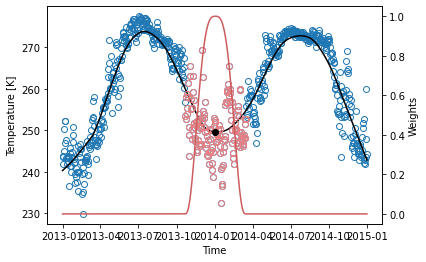

In [2]:
# Daily temperature data from xarray's tutorials
ds = xr.tutorial.open_dataset("air_temperature").resample(time="D").mean()
tas = ds.isel(lat=0, lon=0).air

# Compute the smoothed series
f = 0.2
ys = loess.loess_smoothing(tas, d=1, weights="tricube", f=f, niter=1)

# Plot data points and smoothed series
fig, ax = plt.subplots()
ax.plot(tas.time, tas, "o", fillstyle="none")
ax.plot(tas.time, ys, "k")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature [K]")

## The code below calls internal functions to demonstrate how the weights are computed.

# LOESS algorithms as implemented here use scaled coordinates.
x = tas.time
x = (x - x[0]) / (x[-1] - x[0])
xi = x[366]
ti = tas.time[366]

# Weighting function take the distance with all neighbors scaled by the r parameter as input
r = int(f * tas.time.size)
h = np.sort(np.abs(x - xi))[r]
weights = loess._tricube_weighting(np.abs(x - xi).values / h)

# Plot nearest neighbors and weighing function
wax = ax.twinx()
wax.plot(tas.time, weights, color="indianred")
ax.plot(
    tas.time, tas.where(tas * weights > 0), "o", color="lightcoral", fillstyle="none"
)

ax.plot(ti, ys[366], "ko")
wax.set_ylabel("Weights")
plt.show()

LOESS smoothing can suffer from heavy boundary effects. On the previous graph, we can associate the strange bend on the left end of the line to them. The next example shows a stronger case. Usually, $\frac{f}{2}N$ points on each side should be discarded. On the other hand, LOESS has the advantage of always staying within the bounds of the data.


### LOESS Detrending

In climate science, it can be used in the detrending process. `xclim` provides `sdba.detrending.LoessDetrend` in order to compute trend with the LOESS smoothing and remove them from timeseries.

First we create some toy data with a sinusoidal annual cycle, random noise and a linear temperature increase.

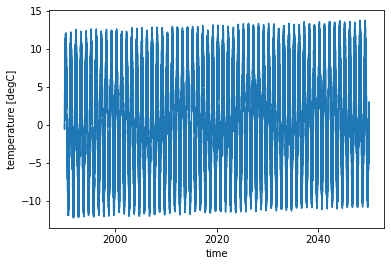

In [3]:
time = xr.cftime_range("1990-01-01", "2049-12-31", calendar="noleap")
tas = xr.DataArray(
    (
        10 * np.sin(time.dayofyear * 2 * np.pi / 365)
        + 5 * (np.random.random_sample(time.size) - 0.5)  # Annual variability
        + np.linspace(0, 1.5, num=time.size)  # Random noise
    ),  # 1.5 degC increase in 60 years
    dims=("time",),
    coords={"time": time},
    attrs={"units": "degC"},
    name="temperature",
)
tas.plot()

Then we compute the trend on the data. Here, we compute on the whole timeseries (`group='time'`) with the parameters suggested above.

In [4]:
from xclim.sdba.detrending import LoessDetrend

# Create the detrending object
det = LoessDetrend(group="time", d=0, niter=2, f=0.2)
# Fitting returns a new object and computes the trend.
fit = det.fit(tas)
# Get the detrended series
tas_det = fit.detrend(tas)

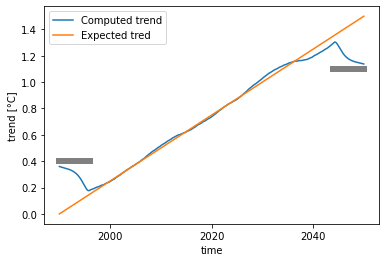

In [5]:
fig, ax = plt.subplots()
fit.ds.trend.plot(ax=ax, label="Computed trend")
ax.plot(time, np.linspace(0, 1.5, num=time.size), label="Expected tred")
ax.plot([time[0], time[int(0.1 * time.size)]], [0.4, 0.4], linewidth=6, color="gray")
ax.plot([time[-int(0.1 * time.size)], time[-1]], [1.1, 1.1], linewidth=6, color="gray")
ax.legend()

As said earlier, this example shows how the Loess has strong boundary effects. It is recommended to remove the $\frac{f}{2}\cdot N$ outermost points on each side, as shown by the  gray bars in the graph above.

## Initializing an Adjustment object from a training dataset

For large scale uses, when the training step deserves its own computation and write to disk, or simply when there are multiples `sim` to be adjusted with the same training, it is helpful to be able to instantiate the Adjustment objects from the training dataset itself. This trick relies on a global attribute "adj_params" set on the training dataset.

In [6]:
import numpy as np
import xarray as xr

# Create toy data for the example, here fake temperature timeseries
t = xr.cftime_range("2000-01-01", "2030-12-31", freq="D", calendar="noleap")
ref = xr.DataArray(
    (
        -20 * np.cos(2 * np.pi * t.dayofyear / 365)
        + 2 * np.random.random_sample((t.size,))
        + 273.15
        + 0.1 * (t - t[0]).days / 365
    ),  # "warming" of 1K per decade,
    dims=("time",),
    coords={"time": t},
    attrs={"units": "K"},
)
sim = xr.DataArray(
    (
        -18 * np.cos(2 * np.pi * t.dayofyear / 365)
        + 2 * np.random.random_sample((t.size,))
        + 273.15
        + 0.11 * (t - t[0]).days / 365
    ),  # "warming" of 1.1K per decade
    dims=("time",),
    coords={"time": t},
    attrs={"units": "K"},
)

ref = ref.sel(time=slice(None, "2015-01-01"))
hist = sim.sel(time=slice(None, "2015-01-01"))

In [7]:
from xclim.sdba.adjustment import QuantileDeltaMapping

QDM = QuantileDeltaMapping.train(
    ref, hist, nquantiles=15, kind="+", group="time.dayofyear"
)
QDM

QuantileDeltaMapping(group=Grouper(add_dims=[], name='time.dayofyear', window=1), kind='+')

The trained `QDM` exposes the training data in the `ds` attribute, Here, we will write it to disk, read it back and initialize an new object from it. Notice the `adj_params` in the dataset, that has the same value as the repr string printed just above. Also, notice the `_xclim_adjustment` attribute that contains a json string so we can rebuild the adjustment object later.

In [8]:
QDM.ds

<xarray.Dataset>
Dimensions:    (quantiles: 17, dayofyear: 365)
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.03333 0.1 0.1667 ... 0.9 0.9667 1.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    af         (dayofyear, quantiles) float64 -1.781 -1.822 ... -2.212 -2.199
    hist_q     (dayofyear, quantiles) float64 255.5 255.5 255.8 ... 258.5 258.6
Attributes:
    group:               time.dayofyear
    group_compute_dims:  ['time']
    group_window:        1
    _xclim_adjustment:   {"py/object": "xclim.sdba.adjustment.QuantileDeltaMa...
    adj_params:          QuantileDeltaMapping(group=Grouper(add_dims=[], name...

In [9]:
QDM.ds.to_netcdf("QDM_training.nc")
ds = xr.open_dataset("QDM_training.nc")
QDM2 = QuantileDeltaMapping.from_dataset(ds)
QDM2

QuantileDeltaMapping(group=Grouper(add_dims=[], name='time.dayofyear', window=1), kind='+')

In the case above, creating a full object from the dataset doesn't make the most sense since we are in the same python session, with the "old" object still available. This method effective when we reload the training data in a different python session, say on another computer. **However, take note that there is no retrocompatiblity insurance.** If the QuantileDeltaMapping class was to change in a new xclim version, one would not be able to create the new object from a dataset saved with the old one.

For the case where we stay in the same python session, it is still useful to trigger the dask computations. For small datasets, that could mean a simple `QDM.ds.load()`, but sometimes even the training data is too large to be full loaded in memory. In that case, we could also do:

In [10]:
QDM.ds.to_netcdf("QDM_training2.nc")
ds = xr.open_dataset("QDM_training2.nc")
ds.attrs["title"] = "This is the dataset, but read from disk."
QDM.set_dataset(ds)
QDM.ds

<xarray.Dataset>
Dimensions:    (quantiles: 17, dayofyear: 365)
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.03333 0.1 0.1667 ... 0.9 0.9667 1.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    af         (dayofyear, quantiles) float64 ...
    hist_q     (dayofyear, quantiles) float64 ...
Attributes:
    group:               time.dayofyear
    group_compute_dims:  time
    group_window:        1
    _xclim_adjustment:   {"py/object": "xclim.sdba.adjustment.QuantileDeltaMa...
    adj_params:          QuantileDeltaMapping(group=Grouper(add_dims=[], name...
    title:               This is the dataset, but read from disk.

In [11]:
QDM2.adjust(sim)

<xarray.DataArray 'scen' (time: 11315)>
array([253.77446157, 255.38017758, 255.00609817, ..., 258.33034612,
       258.32286897, 257.35306735])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:            K
    history:          [2021-12-20 15:57:09] : Bias-adjusted with QuantileDelt...
    bias_adjustment:  QuantileDeltaMapping(group=Grouper(add_dims=[], name='t...

## Retrieving extra output diagnostics

To fully understand what is happening during the bias-adjustment process, sdba can output _diagnostic_ variables, giving more visibility to what the adjustment is doing behind the scene. This behaviour, a `verbose` option, is controlled by the `sdba_extra_output` option, set with `xclim.set_options`. When `True`, `train` calls are instructed to include additional variables to the training datasets. In addition, the `adjust` calls will always output a dataset, with `scen` and, depending on the algorithm, other diagnostics variables. See the documentation of each `Adjustment` objects to see what extra variables are available.

For the moment, this feature is still in construction and only a few `Adjustment` actually provide extra outputs. Please open issues on the Github repo if you have needs or ideas of interesting diagnostic variables.

For example, `QDM.adjust` adds `sim_q`, which gives the quantile of each element of `sim` within its group.

In [12]:
from xclim import set_options

with set_options(sdba_extra_output=True):
    QDM = QuantileDeltaMapping.train(
        ref, hist, nquantiles=15, kind="+", group="time.dayofyear"
    )
    out = QDM.adjust(sim)

out.sim_q

<xarray.DataArray 'sim_q' (time: 11315)>
array([0.06451613, 0.25806452, 0.29032258, ..., 1.        , 1.        ,
       0.93548387])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    group:               time.dayofyear
    group_compute_dims:  time
    group_window:        1
    long_name:           Group-wise quantiles of `sim`.

## Moving window for adjustments

Some Adjustment methods require that the adjusted data (`sim`) be of the same length (same number of points) than the training data (`ref` and `hist`). This requirements often ensure conservation of statistical properties and a better representation of the climate change signal over the long adjusted timeseries.

In opposition to a conventionnal "rolling window", here it is the _years_ that are the base units of the window, not the elements themselves. xclim implements `sdba.construct_moving_yearly_window` and `sdba.unpack_moving_yearly_window` to manipulate data in that goal. The "construct" function cuts the data in overlapping windows of a certain length (in years) and stacks them along a new `"movingdim"` dimension, alike to xarray's `da.rolling(time=win).construct('movingdim')`, but with yearly steps. The step between each window can also be controlled. This argument is an indicator of how many years overlap between each window. With a value of 1 (the default), a window will have `window - 1` years overlapping with the previous one. `step = window` will result in no overlap at all.

By default, the result is chunked along this `'movingdim'` dimension. For this reason, the method is expected to be more computationally efficient (when using `dask`) than looping over the windows.

Note that this results in two restrictions:

1. The constructed array has the same "time" axis for all windows. This is a problem if the actual _year_ is of importance for the adjustment, but this is not the case for any of xclim's current adjustment methods.
2. The input timeseries must be in a calendar with uniform year lengths. For daily data, this means only the "360_day", "noleap" and "all_leap" calendars are supported.

The "unpack" function does the opposite : it concatenates the windows together to recreate the original timeseries. Only the central `step` years are kept from each window. Which means the final timeseries has  `(window - step) / 2` years missing on either side, with the extra year missing on the right in case of an odd `(window - step)`.

Here, as`ref` and `hist` cover 15 years, we will use a window of 15 on sim. With a step of 2, this means the first window goes from 2000 to 2014 (inclusive). The last window goes from 2016 to 2030. `window - step = 13`, so 6 years will be missing at the beginning of the final `scen` and 7 years at the end.

In [13]:
QDM = QuantileDeltaMapping.train(
    ref, hist, nquantiles=15, kind="+", group="time.dayofyear"
)

scen_nowin = QDM.adjust(sim)

In [14]:
sim

<xarray.DataArray (time: 11315)>
array([255.59691 , 257.029095, 256.851727, ..., 260.187388, 260.467391,
       259.565565])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:    K

In [15]:
from xclim.sdba import construct_moving_yearly_window, unpack_moving_yearly_window

sim_win = construct_moving_yearly_window(sim, window=15, step=2)
sim_win

<xarray.DataArray (movingwin: 9, time: 5475)>
array([[255.59691044, 257.02909467, 256.85172658, ..., 257.50399496,
        257.58892003, 258.07838624],
       [256.99867254, 255.54190644, 257.31867788, ..., 257.72085692,
        258.7157493 , 257.18729393],
       [257.07202436, 257.38004424, 256.33351795, ..., 258.15959561,
        258.07819119, 259.20643017],
       ...,
       [257.76118788, 257.06862645, 257.97344573, ..., 259.71242319,
        259.35922404, 258.26011989],
       [257.77660686, 258.62481173, 258.45014242, ..., 259.56973091,
        258.89433718, 259.24574163],
       [257.55834259, 258.44859841, 257.99968426, ..., 260.18738798,
        260.46739059, 259.56556517]])
Coordinates:
  * movingwin  (movingwin) object 2000-01-01 00:00:00 ... 2016-01-01 00:00:00
  * time       (time) object 2000-01-01 00:00:00 ... 2014-12-31 00:00:00
Attributes:
    units:    K

In [16]:
scen_win = unpack_moving_yearly_window(QDM.adjust(sim_win))
scen_win

<xarray.DataArray 'scen' (time: 6570)>
array([255.1351162 , 255.15882559, 255.44721795, ..., 256.11648548,
       257.55886974, 257.37407165])
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2023-12-31 00:00:00
Attributes:
    units:            K
    history:          [2021-12-20 15:57:14] : Bias-adjusted with QuantileDelt...
    bias_adjustment:  QuantileDeltaMapping(group=Grouper(add_dims=[], name='t...

Here is another short example, with an uneven number of years. Here `sim` goes from 2000 to 2029 (30 years instead of 31). With a step of 2 and a window of 15, the first window goes again from 2000 to 2014, but the last one is now from 2014 to 2028. The next window would be 2016-2030, but that last year doesn't exist. The final timeseries is thus from 2006 to 2021, 6 years missing at the beginning, like last time and **8** years missing at the end.

In [17]:
sim_win = construct_moving_yearly_window(
    sim.sel(time=slice("2000", "2029")), window=15, step=2
)
sim_win

<xarray.DataArray (movingwin: 8, time: 5475)>
array([[255.59691044, 257.02909467, 256.85172658, ..., 257.50399496,
        257.58892003, 258.07838624],
       [256.99867254, 255.54190644, 257.31867788, ..., 257.72085692,
        258.7157493 , 257.18729393],
       [257.07202436, 257.38004424, 256.33351795, ..., 258.15959561,
        258.07819119, 259.20643017],
       ...,
       [257.35377224, 256.79917365, 256.65245463, ..., 259.88893176,
        259.05546889, 258.22735855],
       [257.76118788, 257.06862645, 257.97344573, ..., 259.71242319,
        259.35922404, 258.26011989],
       [257.77660686, 258.62481173, 258.45014242, ..., 259.56973091,
        258.89433718, 259.24574163]])
Coordinates:
  * movingwin  (movingwin) object 2000-01-01 00:00:00 ... 2014-01-01 00:00:00
  * time       (time) object 2000-01-01 00:00:00 ... 2014-12-31 00:00:00
Attributes:
    units:    K

In [18]:
sim2 = unpack_moving_yearly_window(sim_win)
sim2

<xarray.DataArray (time: 5840)>
array([257.54494831, 257.53422888, 257.3773679 , ..., 258.32230204,
       259.23087248, 258.02885182])
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2021-12-31 00:00:00
Attributes:
    units:    K

## Full example: Multivariate adjustment in the additive space

The following example shows a complete bias-adjustment workflow using the `PrincipalComponents` method in a multi-variate configuration. Moreover, it uses the trick showed by Alavoine et Grenier (2022) to transform "multiplicative" variable to the "additive" space using log and logit transformations. This way, we can perform multi-variate adjustment with variables that couldn't be used in the same _kind_ of adjustment, like "tas" and "hurs".

We will transform the variables that need it to the additive space, adding some jitter in the process to avoid $log(0)$ situations. Then, we will stack the different variables into a single `DataArray`, allowing us to use to use `PrincipalComponents` in a multi-variate way. Following the PCA, a simple quantile-mapping method is used, both adjustment acting on the residuals, while the mean of the simulated trend is adjusted on its own. Each step will be explained.

First, open the data, convert the calendar and the units. Because we will perform adjustments on "dayofyear" groups (with a window), keeping standard calendars results in a extra "dayofyear" with only a quarter of the data. It's usual to transform to a "noleap" calendar, which drops the 29th of February, as it only has a small impact on the data.

In [19]:
from xclim.testing import open_dataset
from xclim.core.calendar import convert_calendar
from xclim.core.units import convert_units_to
import xclim.sdba as sdba

group = sdba.Grouper('time.dayofyear', window=31)

dref = convert_calendar(
    open_dataset('sdba/ahccd_1950-2013.nc'), 'noleap'
).sel(time=slice('1981', '2010'))
dsim = open_dataset('sdba/CanESM2_1950-2100.nc')

dref = dref.assign(
    tasmax=convert_units_to(dref.tasmax, 'K'),
)
dsim = dsim.assign(
    pr=convert_units_to(dsim.pr, 'mm/d')
)

#### 1. Jitter, additive space transformation and variable stacking
Here, `tasmax` is already ready to be adjusted in an additive way, because all data points are far from the physical zero (0 K). This is not the case for `pr`, which is why we want to transform that variable to the additive space, to avoid splitting our workflow in two. For `pr` the "log" transformation is simply:

$$ pr' = \ln\left(pr - b\right) $$

where $b$ is the lower bound, here 0 mm/d. However, we could have exact zeros (0 mm/d) in the datasets, which will translate into $-\infty$. To avoid this, we simply replace the smallest values by a random distribution of very small, but not problematic, values. In the following, all values below 0.1 mm/d are replace by a uniform random distribution of values within the range (0, 0.1) mm/d (bounds excluded).

Finally, the variables are stacked together into a single DataAray.

In [20]:
dref_as = dref.assign(
    pr=sdba.processing.to_additive_space(
        sdba.processing.jitter(dref.pr, lower='0.1 mm/d', minimum='0 mm/d'),
        lower_bound='0 mm/d',
        trans='log'
    )
)
ref = sdba.stack_variables(dref_as)

dsim_as = dsim.assign(
    pr=sdba.processing.to_additive_space(
        sdba.processing.jitter(dsim.pr, lower='0.1 mm/d', minimum='0 mm/d'),
        lower_bound='0 mm/d',
        trans='log'
    )
)
sim = sdba.stack_variables(dsim_as)
sim

<xarray.DataArray 'multivariate' (variables: 2, time: 55115, location: 3)>
array([[[ 2.4951415e-01, -8.2575524e-01,  2.4951415e-01],
        [ 2.6499695e-01, -4.1112199e-01,  2.6499695e-01],
        [-1.9535363e-01, -5.6355534e+00, -1.9535363e-01],
        ...,
        [ 3.2132244e+00, -2.2834629e-01,  3.2132244e+00],
        [ 1.6713389e+00,  1.7489431e+00,  1.6713389e+00],
        [ 7.5195438e-01,  2.4332016e+00,  7.5195438e-01]],

       [[ 2.7815024e+02,  2.7754898e+02,  2.7815024e+02],
        [ 2.8335815e+02,  2.7690921e+02,  2.8335815e+02],
        [ 2.8153192e+02,  2.7668036e+02,  2.8153192e+02],
        ...,
        [ 2.8901334e+02,  2.8192789e+02,  2.8901334e+02],
        [ 2.8510699e+02,  2.8142294e+02,  2.8510699e+02],
        [ 2.8404471e+02,  2.8160156e+02,  2.8404471e+02]]], dtype=float32)
Coordinates:
  * time       (time) object 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
    lat        (location) float64 49.1 67.8 48.8
    lon        (location) float64 -123.1 -115.1 -78.2
  * location   (location) object 'Vancouver' 'Kugluktuk' 'Amos'
  * variables  (variables) <U6 'pr' 'tasmax'
Attributes:
    institution:                     CanESM2
    institute_id:                    CCCma
    experiment_id:                   rcp85
    source:                          CanESM2 2010 atmosphere: CanAM4 (AGCM15i...
    model_id:                        CanESM2
    forcing:                         GHG,Oz,SA,BC,OC,LU,Sl (GHG includes CO2,...
    parent_experiment_id:            historical
    parent_experiment_rip:           r1i1p1
    branch_time:                     56940.0
    contact:                         cccma_info@ec.gc.ca
    references:                      http://www.cccma.ec.gc.ca/models
    initialization_method:           1
    physics_version:                 1
    tracking_id:                     17560481-e4c5-43c9-bc3f-950732f21588
    branch_time_YMDH:                2006:01:01:00
    CCCma_runid:                     IDR
    CCCma_parent_runid:              IGM
    CCCma_data_licence:              1) GRANT OF LICENCE - The Government of ...
    product:                         output
    experiment:                      RCP8.5
    frequency:                       day
    creation_date:                   2011-04-10T11:24:15Z
    history:                         2021-04-23T12:00:00: Extraction of times...
    Conventions:                     CF-1.4
    project_id:                      CMIP5
    table_id:                        Table day (28 March 2011) f9d6cfec5981bb...
    title:                           Test dataset for xclim.sdba - model data
    parent_experiment:               historical
    modeling_realm:                  atmos
    realization:                     1
    cmor_version:                    2.5.4
    DODS_EXTRA.Unlimited_Dimension:  time
    description:                     Extracted from CMIP5 CanESM2 hist+rcp85 ...
    units:

#### 2. Get residuals and trends
The adjustment will be performed on residuals only. The adjusted timeseries `sim` will be detrended with the LOESS routine described above. Because of the short length of  `ref` and `hist` and the potential boundary effects of using LOESS with them, we compute the 30-year mean. In other words, instead of _detrending_ we are _normalizing_ those inputs.

While the residuals are adjusted with `PrincipalComponents` and `EmpiricalQuantileMapping`, the trend of  `sim` still needs to be offset according to the means of `ref` and `hist`. This is similar to what `DetrendedQuantileMapping` does. The offset step could have been done on the trend itself or at the end on `scen`, it doesn't really matter. We do it here because it keeps it close to where the `scaling` is computed.

In [21]:
ref_res, ref_norm = sdba.processing.normalize(ref, group=group, kind='+')
hist_res, hist_norm = sdba.processing.normalize(sim.sel(time=slice('1981', '2010')), group=group, kind='+')
scaling = sdba.utils.get_correction(hist_norm, ref_norm, kind='+')

In [22]:
sim_scaled = sdba.utils.apply_correction(
    sim,
    sdba.utils.broadcast(scaling, sim, group=group),
    kind='+'
)

loess = sdba.detrending.LoessDetrend(group=group, f=0.2, d=0, kind='+', niter=1)
simfit = loess.fit(sim_scaled)
sim_res = simfit.detrend(sim_scaled)

#### 3. Adjustments
Following, Alavoine et Grenier (2022), we decided to perform the multivariate Principal Components adjustment first and then re-adjust with the simple quantile-mapping.

In [23]:
PCA = sdba.adjustment.PrincipalComponents.train(
    ref_res,
    hist_res,
    group=group,
    crd_dim='variables',
    best_orientation='simple'
)

scen1_res = PCA.adjust(sim_res)

In [24]:
EQM = sdba.adjustment.EmpiricalQuantileMapping.train(
    ref_res,
    scen1_res.sel(time=slice('1981', '2010')),
    group=group,
    nquantiles=50,
    kind='+'
)

scen2_res = EQM.adjust(
    scen1_res,
    interp='linear',
    extrapolation='constant'
)

#### 4. Re-trend and transform back to the physical space
Add back the trend (which includes the scaling), unstack the variables to a dataset and transform `pr` back to the physical space. All functions have conserved and handled the attributes, so we don't need to repeat the additive space bounds. The annual cycle of both variables on the reference period in Vancouver is plotted to confirm the adjustment add a positive effect.

In [25]:
scen = simfit.retrend(scen2_res)
dscen_as = sdba.unstack_variables(scen)
dscen = dscen_as.assign(
    pr=sdba.processing.from_additive_space(dscen_as.pr)
)

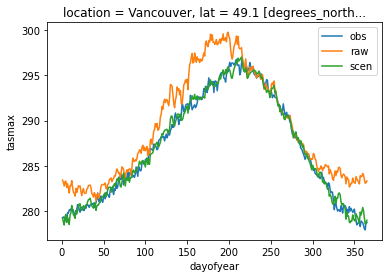

In [26]:
dref.tasmax.sel(time=slice('1981', '2010'), location='Vancouver').groupby('time.dayofyear').mean().plot(label='obs')
dsim.tasmax.sel(time=slice('1981', '2010'), location='Vancouver').groupby('time.dayofyear').mean().plot(label='raw')
dscen.tasmax.sel(time=slice('1981', '2010'), location='Vancouver').groupby('time.dayofyear').mean().plot(label='scen')
plt.legend()

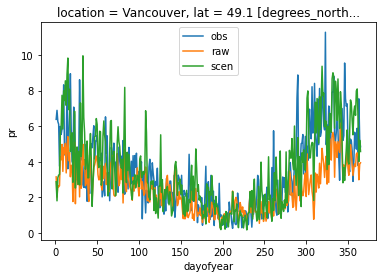

In [27]:
dref.pr.sel(time=slice('1981', '2010'), location='Vancouver').groupby('time.dayofyear').mean().plot(label='obs')
dsim.pr.sel(time=slice('1981', '2010'), location='Vancouver').groupby('time.dayofyear').mean().plot(label='raw')
dscen.pr.sel(time=slice('1981', '2010'), location='Vancouver').groupby('time.dayofyear').mean().plot(label='scen')
plt.legend()